/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Training examples: 2000
Eval examples: 200
trainable params: 294,912 || all params: 124,734,720 || trainable%: 0.23643136409814364
Starting training...


/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/layer.py:711: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss
1,0.986900,0.796396
2,0.844300,0.762114
3,0.947400,0.756021


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Evaluation results: {'eval_loss': 0.7560210227966309, 'eval_runtime': 4.9915, 'eval_samples_per_second': 40.068, 'eval_steps_per_second': 10.017, 'epoch': 3.0}


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



=== Testing Fine-tuned Model ===

Q: Which NFL team represented the AFC at Super Bowl 50?
Predicted: Denver Broncos
Ground Truth: Denver Broncos

Q: Which NFL team represented the NFC at Super Bowl 50?
Predicted: Denver Broncos
Ground Truth: Carolina Panthers

Q: Where did Super Bowl 50 take place?
Predicted: Levi's Stadium
Ground Truth: Santa Clara, California



SQuAD Metrics: {'exact_match': 40.0, 'f1': 40.0}


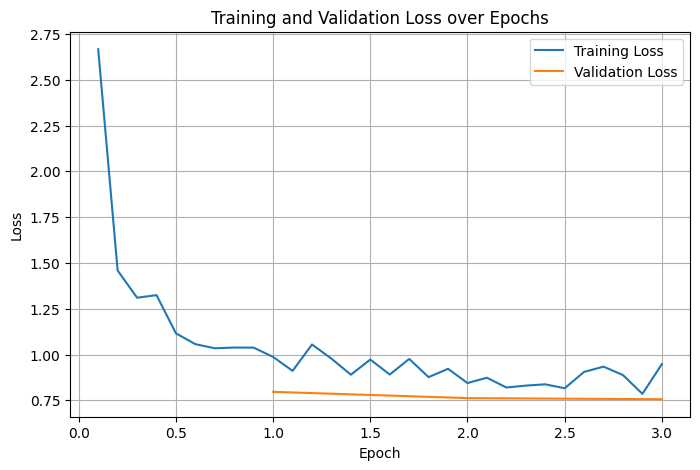

In [2]:
import torch
import gc
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    AutoConfig,
    TrainingArguments,
    Trainer
)
from peft import LoraConfig, TaskType, get_peft_model, AutoPeftModelForCausalLM
import evaluate
import matplotlib.pyplot as plt

# Device selection: Use Apple MPS, CUDA, or CPU in that order
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load tokenizer and model
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token  # Set pad token as EOS token to avoid warnings

config = AutoConfig.from_pretrained(model_name)
config.pad_token_id = tokenizer.pad_token_id

model = AutoModelForCausalLM.from_pretrained(model_name, config=config).to(device)

# Load and prepare dataset (SQuAD)
dataset = load_dataset("squad")
vali_ds = dataset["validation"].select(range(5))  # Select first 5 samples for quick validation example

# Split train dataset into train and eval subsets with shuffling and fixed seed
split_ds = dataset["train"].train_test_split(test_size=0.1, seed=42)
train_ds = split_ds["train"].shuffle(seed=42).select(range(2000))  # Select 2000 for training
eval_ds = split_ds["test"].shuffle(seed=42).select(range(200))  # Select 200 for evaluation

# Clear unused memory
del dataset, split_ds
gc.collect()

def preprocess_function(examples):
    """
    Tokenize and prepare input and labels for causal language modeling.
    - Combine context, question, and answer into a prompt.
    - Append EOS token after answer.
    - Mask prompt tokens in labels with -100 so loss only calculated on answer tokens.
    Args:
        examples (dict): Batch of examples from dataset containing 'context', 'question', 'answers'
    Returns:
        dict: Tokenized inputs and labels
    """
    inputs = []
    labels = []

    for context, question, answers in zip(examples['context'], examples['question'], examples['answers']):
        if len(answers['text']) == 0:
            continue
        answer_text = answers['text'][0]
        prompt = f"Context: {context}\nQuestion: {question}\nAnswer:"
        full_text = prompt + " " + answer_text + tokenizer.eos_token
        inputs.append(full_text)

        # Tokenize full text and prompt separately to identify prompt length
        input_ids = tokenizer(full_text, truncation=True, max_length=512, padding=False)['input_ids']
        prompt_ids = tokenizer(prompt, truncation=True, max_length=512, padding=False)['input_ids']

        label_ids = input_ids.copy()
        # Mask prompt tokens to ignore in loss computation
        label_ids[:len(prompt_ids)] = [-100] * len(prompt_ids)
        labels.append(label_ids)

    model_inputs = tokenizer(inputs, truncation=True, max_length=512, padding=False)
    model_inputs["labels"] = labels
    return model_inputs

class QADataCollator:
    """
    Custom data collator for padding inputs and labels to the same length.
    Pads inputs with tokenizer's pad token and labels with -100.
    """
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def __call__(self, features):
        input_ids = [f["input_ids"] for f in features]
        attention_mask = [f["attention_mask"] for f in features]
        labels = [f["labels"] for f in features]

        # Pad input_ids and attention masks to longest sequence in batch
        batch = self.tokenizer.pad(
            {"input_ids": input_ids, "attention_mask": attention_mask},
            padding="longest",
            return_tensors="pt"
        )

        max_len = batch["input_ids"].shape[1]
        padded_labels = []
        for label in labels:
            pad_len = max_len - len(label)
            if pad_len < 0:
                padded = label[:max_len]  # Truncate if label longer than max length
            else:
                padded = label + [-100] * pad_len  # Pad labels with -100 (ignore index)
            padded_labels.append(padded)

        batch["labels"] = torch.tensor(padded_labels)
        return batch

# Tokenize train and eval datasets with preprocessing
tok_train_ds = train_ds.map(preprocess_function, batched=True, remove_columns=train_ds.column_names)
tok_eval_ds = eval_ds.map(preprocess_function, batched=True, remove_columns=eval_ds.column_names)

print(f"Training examples: {len(tok_train_ds)}")
print(f"Eval examples: {len(tok_eval_ds)}")

# Freeze all base model parameters before applying LoRA to fine-tune fewer params
for param in model.parameters():
    param.requires_grad = False

# Configure LoRA adapter for GPT-2 causal LM
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.CAUSAL_LM,
    target_modules=["c_attn"]
)

# Get model with LoRA adapters
lora_model = get_peft_model(model, lora_config)
lora_model.print_trainable_parameters()

lora_model.to(device)
lora_model.train()

# Instantiate data collator for dynamic padding
data_collator = QADataCollator(tokenizer)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    learning_rate=2e-4,
    num_train_epochs=3,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=50,
    save_total_limit=2,
    load_best_model_at_end=True,
    report_to="none"  # Disable reporting to external services
)

# Initialize Trainer with model, args, datasets, data collator and tokenizer
trainer = Trainer(
    model=lora_model,
    args=training_args,
    train_dataset=tok_train_ds,
    eval_dataset=tok_eval_ds,
    data_collator=data_collator,
    tokenizer=tokenizer
)

print("Starting training...")
trainer.train()

# Evaluate trained model on eval dataset
evaluation_result = trainer.evaluate()
print("Evaluation results:", evaluation_result)

# Save fine-tuned model including LoRA adapters
trainer.save_model("./lora_gpt2_squad")

def generate_answer(model, tokenizer, context, question, max_new_tokens=50):
    """
    Generate an answer to a question given a context using the fine-tuned model.
    Args:
        model: Fine-tuned causal LM model
        tokenizer: Corresponding tokenizer
        context (str): Context passage
        question (str): Question text
        max_new_tokens (int): Maximum tokens to generate
    Returns:
        str: Generated answer text
    """
    prompt = f"Context: {context}\nQuestion: {question}\nAnswer:"
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    output = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=True,
        top_k=50,
        top_p=0.9,
        temperature=1.0,
        pad_token_id=tokenizer.eos_token_id
    )
    decoded = tokenizer.decode(output[0], skip_special_tokens=True)
    # Extract only the answer part after "Answer:"
    return decoded.split("Answer:")[-1].strip()

# Load trained model with LoRA adapters for testing
ft_model = AutoPeftModelForCausalLM.from_pretrained("./lora_gpt2_squad")
ft_model.eval().to(device)

print("\n=== Testing Fine-tuned Model ===")
for i, example in enumerate(vali_ds.select(range(3))):
    context = example["context"]
    question = example["question"]
    ground_truth = example["answers"]["text"][0]

    prediction = generate_answer(ft_model, tokenizer, context, question)
    print(f"\nQ: {question}\nPredicted: {prediction}\nGround Truth: {ground_truth}")

# Load SQuAD evaluation metric
squad_metric = evaluate.load("squad")
predictions, references = [], []

# Generate predictions and prepare references for evaluation on validation set
for example in vali_ds:
    context = example["context"]
    question = example["question"]
    ground_truth = example["answers"]["text"][0]
    prediction = generate_answer(ft_model, tokenizer, context, question)
    predictions.append({"id": example["id"], "prediction_text": prediction})
    references.append({"id": example["id"], "answers": {"text": [ground_truth], "answer_start": [0]}})

# Compute SQuAD metrics (Exact Match and F1)
results = squad_metric.compute(predictions=predictions, references=references)
print(f"\nSQuAD Metrics: {results}")

import pandas as pd

# Extract training logs to plot loss curves
logs = trainer.state.log_history
df_logs = pd.DataFrame(logs)

# Compute average training and evaluation loss per epoch
train_loss_per_epoch = df_logs[df_logs['loss'].notna()].groupby('epoch')['loss'].mean()
eval_loss_per_epoch = df_logs[df_logs['eval_loss'].notna()].groupby('epoch')['eval_loss'].mean()

# Plot training and validation loss over epochs
plt.figure(figsize=(8,5))
plt.plot(train_loss_per_epoch.index, train_loss_per_epoch.values, label="Training Loss")
plt.plot(eval_loss_per_epoch.index, eval_loss_per_epoch.values, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()


In [3]:
import shutil

# Zip the folder containing the fine-tuned model
shutil.make_archive("lora_gpt2_squad", 'zip', "./lora_gpt2_squad")


'/content/lora_gpt2_squad.zip'

In [4]:
from google.colab import files

# Download the zip file
files.download("lora_gpt2_squad.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>